In [90]:
import pandas as pd
import re
from nltk.corpus import stopwords 
from nltk import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS
from matplotlib import pyplot as plt
import nltk
from nltk.sentiment import vader
from nltk.sentiment.vader import SentimentIntensityAnalyzer
vader_model = SentimentIntensityAnalyzer()
import spacy
from sklearn import metrics
from matplotlib import pyplot as plt
import numpy as np
import pickle
import numpy as np
import seaborn as sns
nlp = spacy.load('en')


In [43]:
df = pd.read_csv("mbti_1.csv")

# Count Different types of pronouns

In [44]:
first_pron_pat = r"(?i)\b(I|me|my|mine|myself|we|us|our|ours|ourselves)\b"
first_pron_num = 10
second_pron_pat = r"(?i)\b(you|your|yours|yourself|yourselves)\b"
second_pron_num = 5
third_pron_pat = r"(?i)\b(he|him|his|himself|she|her|hers|herself|they|them|their|theirs|themselves|it|its|itself)\b"
third_pron_num = 16
link_pat = r"http"

In [45]:
df['1st_pron_count'] = df['posts'].str.count(pat=first_pron_pat)/first_pron_num
df['2nd_pron_count'] = df['posts'].str.count(pat=second_pron_pat)/second_pron_num
df['3rd_pron_count'] = df['posts'].str.count(pat=third_pron_pat)/third_pron_num
df['link_count'] = df['posts'].str.count(pat=link_pat)
df['comment_count'] = df['posts'].str.count(pat=r"\|\|\|")+1
df['org_comment_count'] = df['comment_count'] - df['link_count']

In [46]:
df_1st = df.groupby(['type'])['1st_pron_count'].sum()/df.groupby(['type'])['org_comment_count'].sum()
df_1st = df_1st .to_frame('1st_pron_count').sort_values(by=['1st_pron_count'],ascending=False)

# Average 1st person prounouns count

(array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 ]),
 <a list of 7 Text yticklabel objects>)

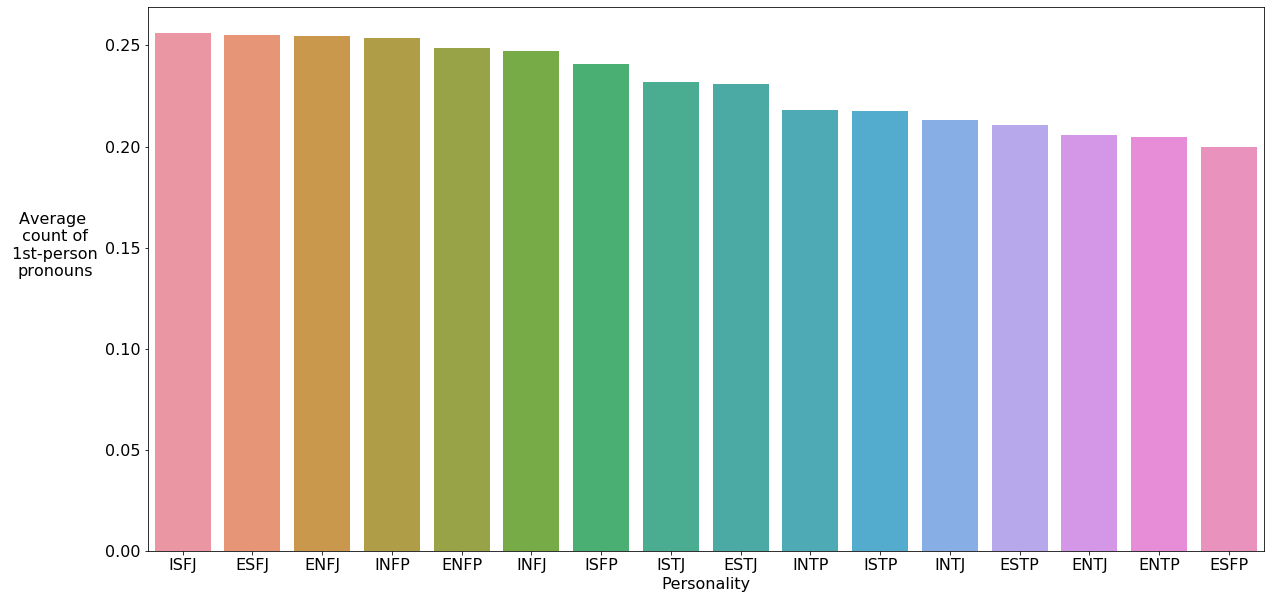

In [47]:
plt.figure(figsize=(20,10))
sns.barplot(x=df_1st.index,y=df_1st['1st_pron_count'])
plt.ylabel('Average \n count of \n 1st-person \npronouns', fontsize=16,rotation=0,labelpad=50)
plt.xlabel('Personality', fontsize=16)
plt.xticks(fontsize=16, rotation=0)
plt.yticks(fontsize=16, rotation=0)

# Average 2nd person prounouns count

In [48]:
df_2nd = df.groupby(['type'])['2nd_pron_count'].sum()/df.groupby(['type'])['org_comment_count'].sum()
df_2nd = df_2nd.to_frame('2nd_pron_count').sort_values(by=['2nd_pron_count'],ascending=False)

(array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16]),
 <a list of 9 Text yticklabel objects>)

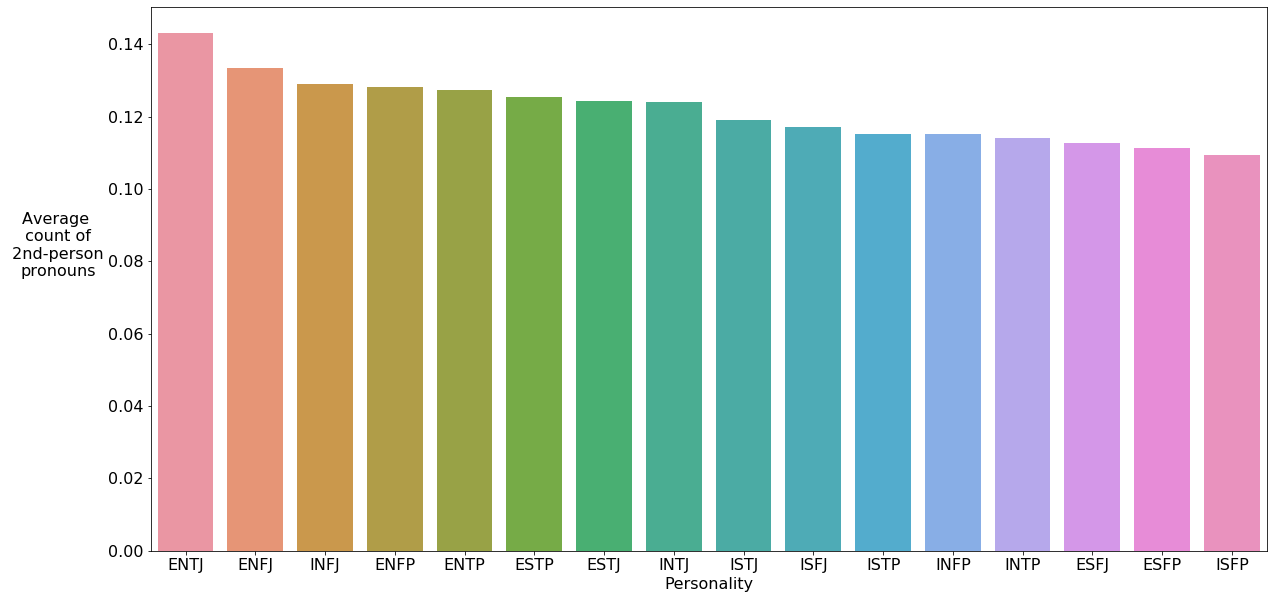

In [49]:
plt.figure(figsize=(20,10))
sns.barplot(x=df_2nd.index,y=df_2nd['2nd_pron_count'])
plt.ylabel('Average \n count of \n 2nd-person \npronouns', fontsize=16,rotation=0,labelpad=50)
plt.xlabel('Personality', fontsize=16)
plt.xticks(fontsize=16, rotation=0)
plt.yticks(fontsize=16, rotation=0)

In [50]:
df_3rd = df.groupby(['type'])['3rd_pron_count'].sum()/df.groupby(['type'])['org_comment_count'].sum()
df_3rd = df_3rd.to_frame('3rd_pron_count').sort_values(by=['3rd_pron_count'],ascending=False)

(array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07]),
 <a list of 8 Text yticklabel objects>)

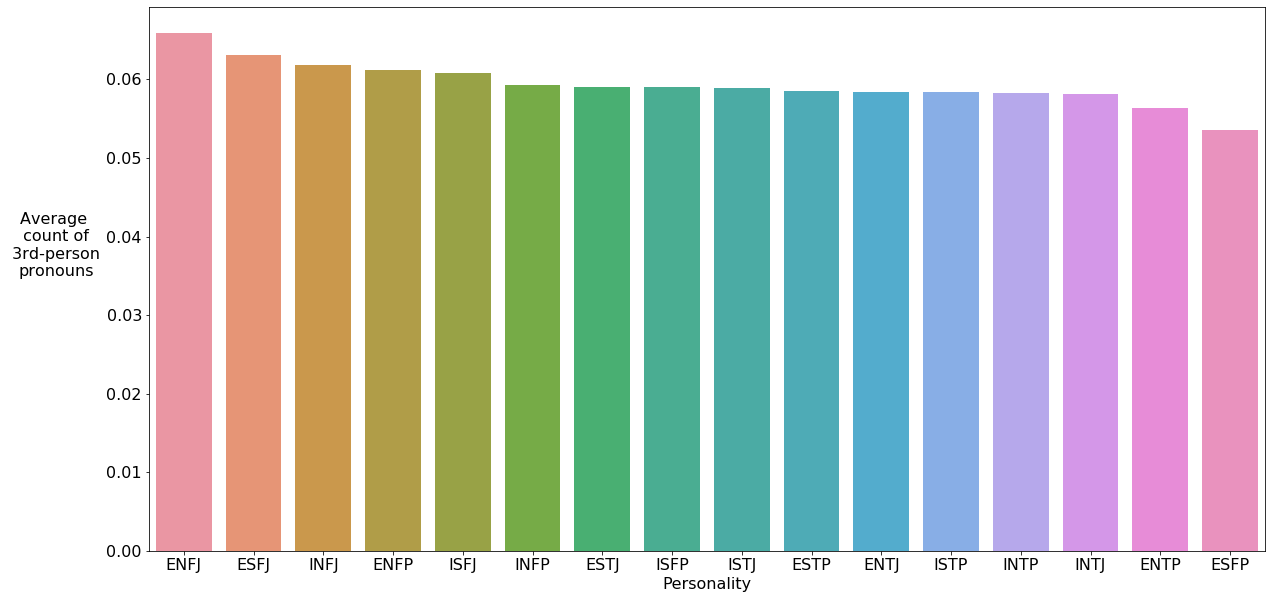

In [51]:
plt.figure(figsize=(20,10))
sns.barplot(x=df_3rd.index,y=df_3rd['3rd_pron_count'])
plt.ylabel('Average \n count of \n 3rd-person \npronouns', fontsize=16,rotation=0,labelpad=50)
plt.xlabel('Personality', fontsize=16)
plt.xticks(fontsize=16, rotation=0)
plt.yticks(fontsize=16, rotation=0)

In [52]:
def subtype_plot(df,vs_func):
    pron_type = ['1st_pron','2nd_pron','3rd_pron']
    pron_name = ['1st-person pronouns', '2nd-person pronouns', '3rd-person pronouns']
    frames = []
    for i, pron in enumerate(pron_type):
        df_sub=df.groupby(df['type'].apply(vs_func))[pron+'_count'].sum()\
        /df.groupby(df['type'].apply(vs_func))['org_comment_count'].sum()

        df_sub = pd.DataFrame({'Personality': df_sub.index, 'Type of pronouns':pron_name[i],'Average count':df_sub.values})
        frames.append(df_sub)
    result = pd.concat(frames)
    sns.barplot(x='Type of pronouns', y='Average count', hue='Personality', data=result,palette = 'pastel')

# Comparison between average pronouns count for the given pair of sub-personality

In [53]:
E_vs_I = lambda x: 'Extroversion' if x[0] == 'E' else 'Introversion'
N_vs_S = lambda x: 'Intuition' if x[1] =='N' else 'Sensing'
T_vs_F = lambda x: 'Thinking' if x[2] == 'T' else 'Feeling'
J_vs_P = lambda x: 'Judging' if x[3] == 'J' else 'Perceving'

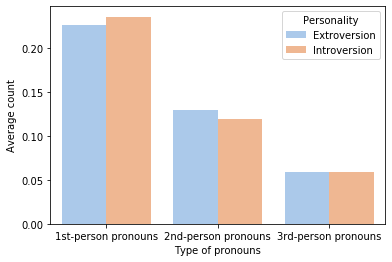

In [54]:
subtype_plot(df,E_vs_I)

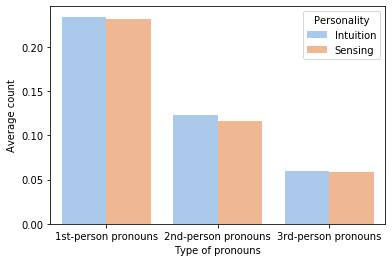

In [55]:
subtype_plot(df,N_vs_S)

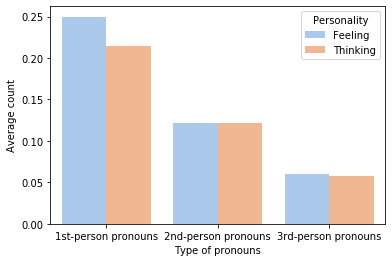

In [56]:
subtype_plot(df,T_vs_F)

"Feeling" and "Thinking" are the decision-making functions.

Those who prefer thinking tend to decide things from a more detached standpoint while those who prefer feeling tend to come to decisions by associating or empathizing with the situation.

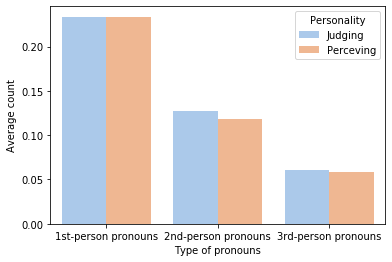

In [57]:
subtype_plot(df,J_vs_P)

In [68]:
def pie_chart(df,name,ax):
    data = df.loc[name].values
    ingredients = df.loc[name].index
    wedges, texts, autotexts = ax.pie(data,autopct='%1.1f%%',
                                      textprops=dict(color="w"),pctdistance=0.6, normalize=True
                                      )
    ax.set_title(name,size=16)

# Link Information Parsing

In [84]:
youtube_links = {}
def get_link_ratio(x):
    '''
    returns a dictionary that holds ratios of links to non-links for each 
    personality type :x: input csv
    '''
    input_file = open(x, 'r')
    input_file.readline()
    output_dict = {}
    comment_dict = {}
    link_dict = {}
    youtube_link_starter = 'http://www.youtube.com/watch?v='
    youtube_link_code_length = 11
    global youtube_links
    while True:
        line = input_file.readline()
        if not line:
            break
        personality_type, sep, data = line.partition(',')
        data = data[1:len(data) - 1]
        comments = data.split('|||')
        link_count = 0
        for comment in comments:
            if 'http://' in comment:
                while youtube_link_starter in comment:
                    start_index = comment.find(youtube_link_starter)
                    youtube_link = comment[start_index:start_index + len(youtube_link_starter) + youtube_link_code_length]
                    youtube_links.setdefault(personality_type, []).append(youtube_link)
                    #output_file.write('{0}\n'.format(youtube_link))
                    comment = comment[:start_index] + comment[start_index+len(youtube_link_starter) + youtube_link_code_length:]
                link_count += 1
        comment_dict[personality_type] = comment_dict.get(personality_type,0) + len(comments)
        link_dict[personality_type] = link_dict.get(personality_type,0) + link_count
    for key in comment_dict.keys():
        output_dict[key] = 100 * link_dict[key]/comment_dict[key]
    input_file.close()
    #output_file.close
    return output_dict

In [85]:
def get_avg_views(x):
    '''
    calculate avg views per video for each personality type :x: dictionary of 
    personality types and links; only keys of dictionary are used
    '''
    output_dictionary = {}
    for k in x.keys():
        file = open('link_processing/link_data/{0}.csv'.format(k),"r")
        index = 0
        count = 0
        while True:
            line = file.readline()
            if not line:
                break
            comma_count = line.count(',')
            count += int(line.split(',')[comma_count - 1])
            index += 1
        if(index < 30):
            count = 0
        output_dictionary[k] = int(count/index)
        file.close()
    return output_dictionary

In [93]:
def make_avg_link_chart(x):
    '''
    Outputs a visualization of the average links per personality :x: a dictionary
    of personality types and their number of average links
    '''
    plt.figure(figsize=(20,10))
    sns.barplot(x=np.array(list(x.values())), y=np.array(list(x.keys())))
    plt.ylabel('Type', fontsize=16)
    plt.xlabel('Number of Links (Per 100 Posts)', fontsize=16)
    plt.xticks(fontsize=16, rotation=0)
    plt.yticks(fontsize=16, rotation=0)
    plt.title('Average Links Per 100 Posts By Personality')
    plt.show()

In [94]:
def make_avg_views_chart(x):
    '''
    Outputs a visualization of the average views per personality :x: a dictionary
    of personality types and their number of average views
    '''
    plt.figure(figsize=(20,10))
    sns.barplot(x=np.array(list(x.values())), y=np.array(list(x.keys())))
    plt.ylabel('Type', fontsize=16)
    plt.xlabel('Average Views', fontsize=16)
    plt.xticks(fontsize=16, rotation=0)
    plt.yticks(fontsize=16, rotation=0)
    plt.title('Average View Per Link By Personality')
    plt.show()

{'ESFJ': 1.3875123885034688, 'ESTJ': 1.6137428422696511, 'ENTP': 2.6983797873285744, 'ENTJ': 2.8475117537478933, 'ESFP': 2.889390519187359, 'ESTP': 3.1358081623241874, 'ENFP': 3.1584729469925845, 'ENFJ': 3.165374677002584, 'ISFJ': 3.201576160571358, 'INFJ': 3.3062894390125512, 'INTJ': 3.6820338853843073, 'ISTJ': 3.7929990921012813, 'ISTP': 3.921687477269972, 'INTP': 3.974178885399075, 'INFP': 4.2340416054167225, 'ISFP': 5.1692307692307695}


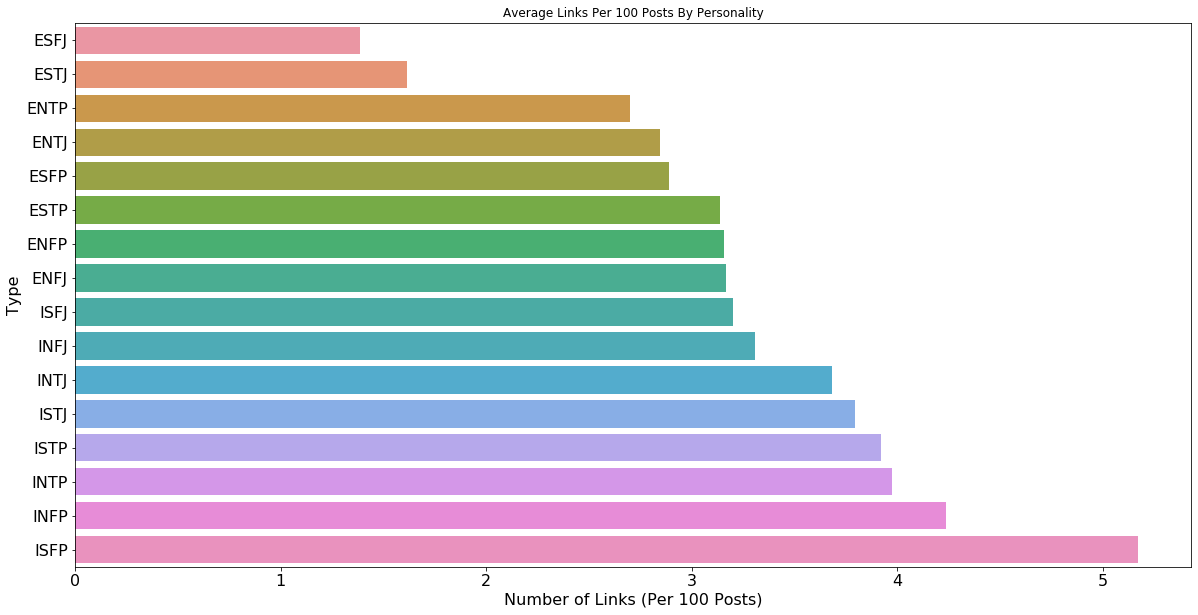

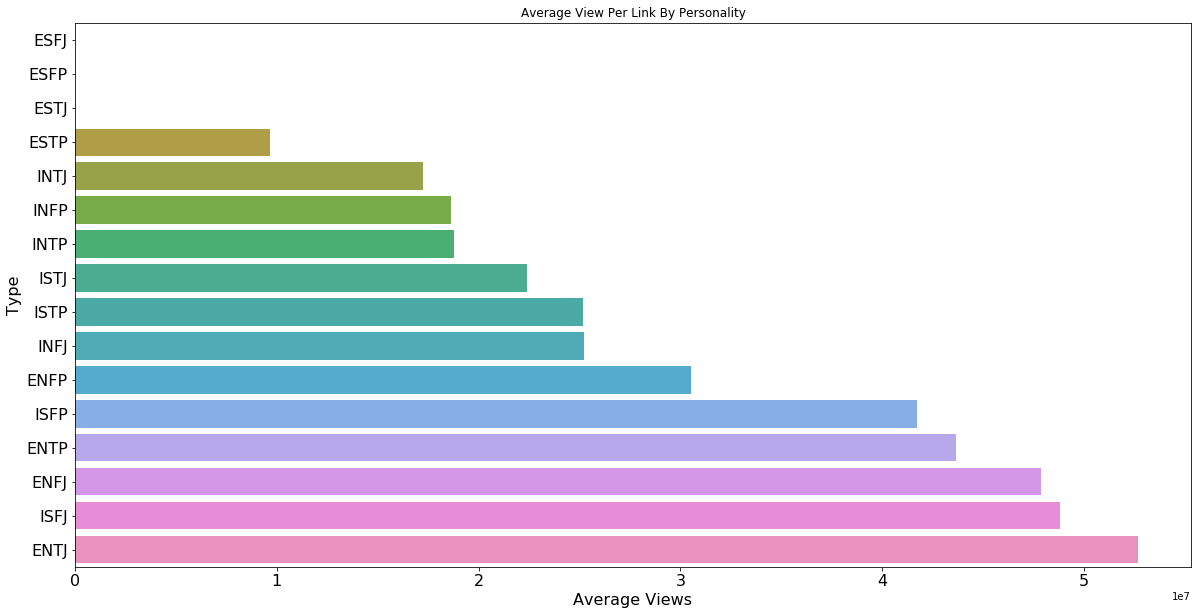

In [95]:
#Get link ratio, store for other functions
x = get_link_ratio('mbti_1.csv')
x = {k: v for k, v in sorted(x.items(), key=lambda item: item[1])}

print(x)
#Visualize link rations
make_avg_link_chart(x)


# create data files WARNING function makes ~11000 http requests, runtime ~ 2 hours
# make_video_data_files(youtube_links)

#Find average views per video
y = (get_avg_views(youtube_links))
y = {k: v for k, v in sorted(y.items(), key=lambda item: item[1])}

#Visualize average view count
make_avg_views_chart(y)

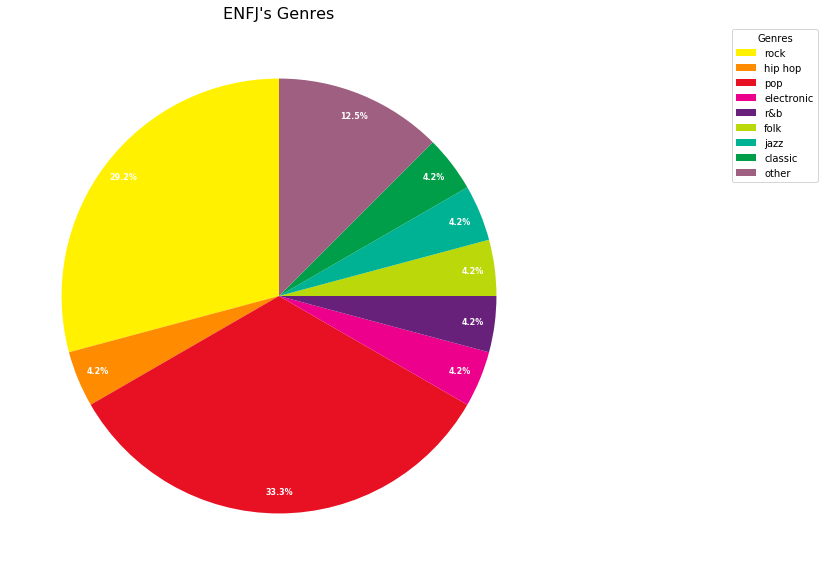

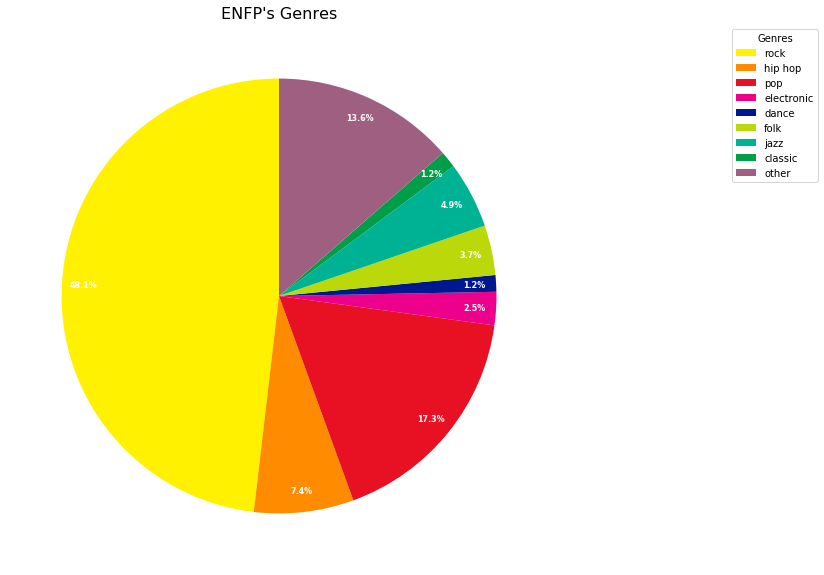

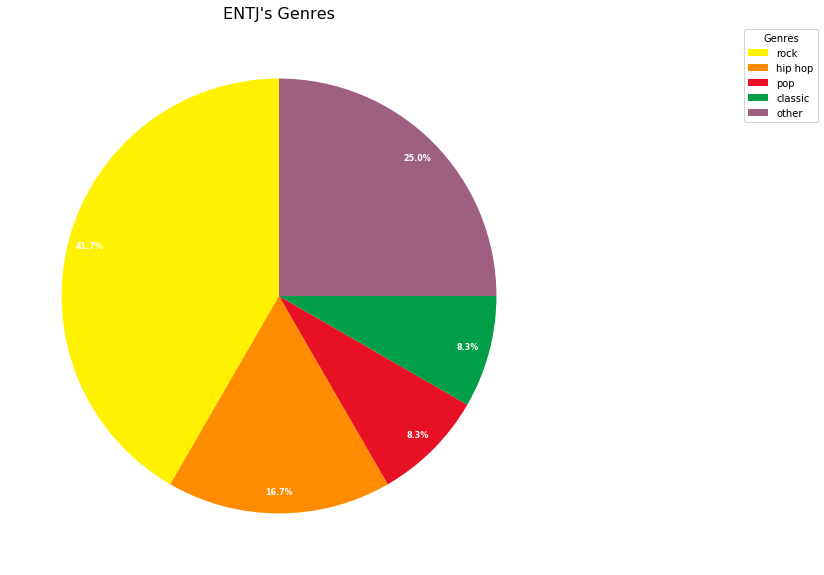

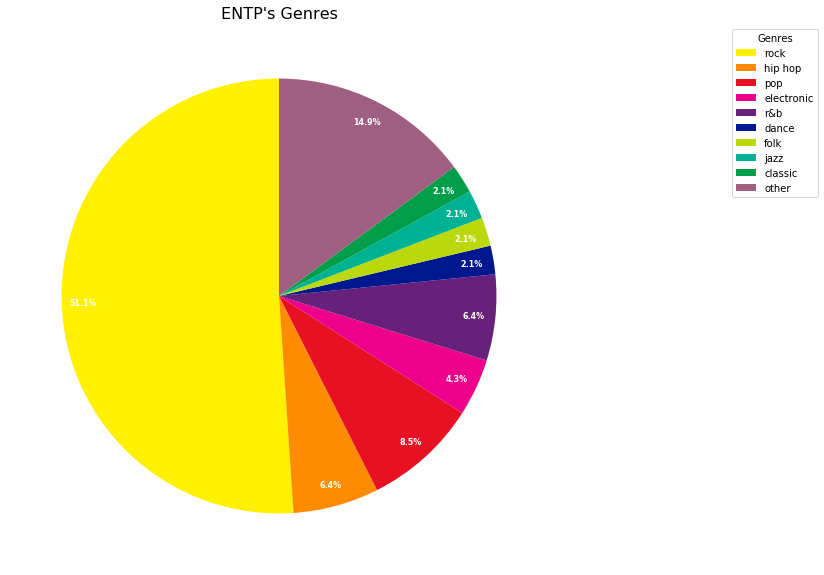

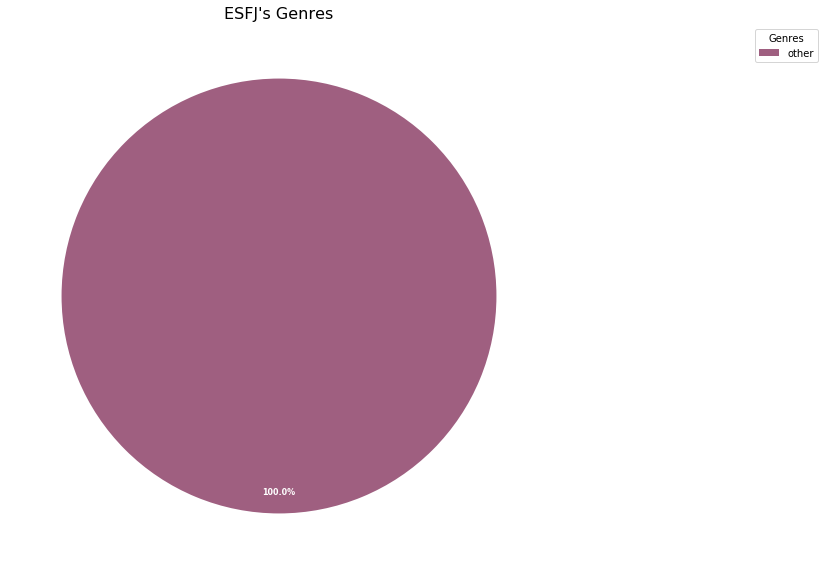

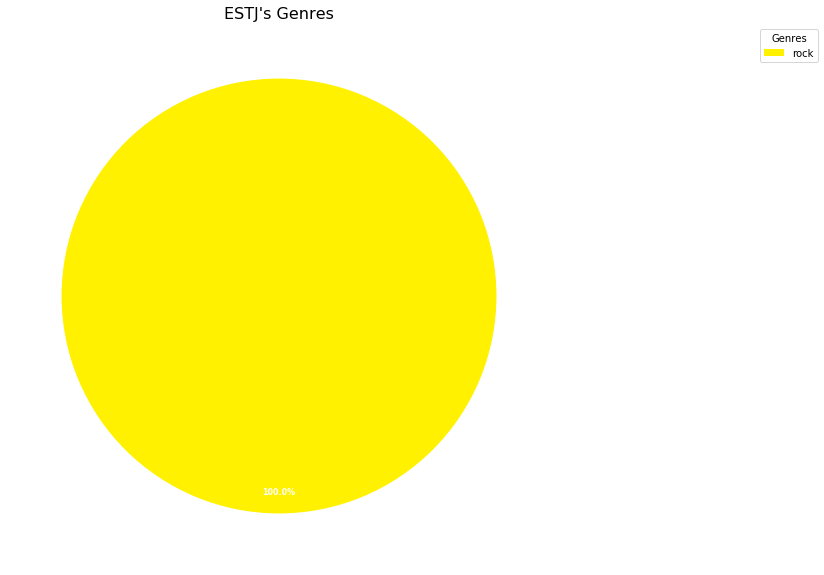

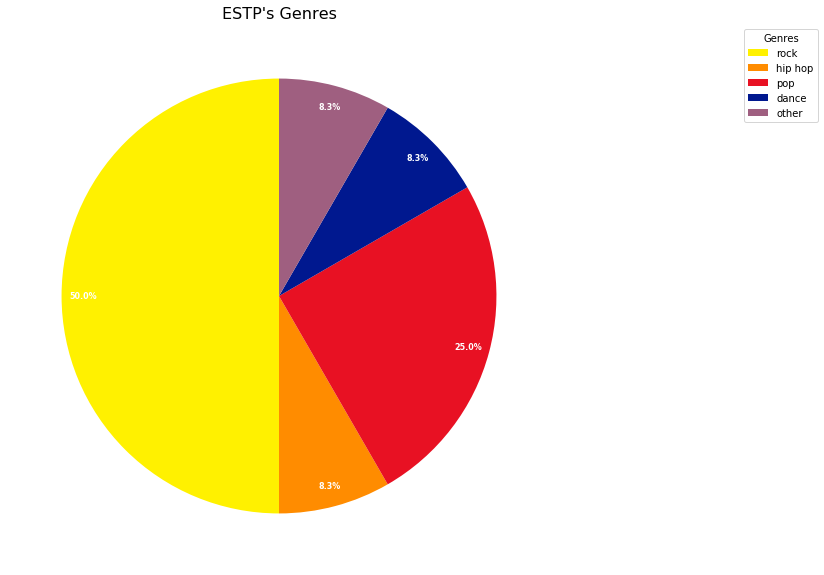

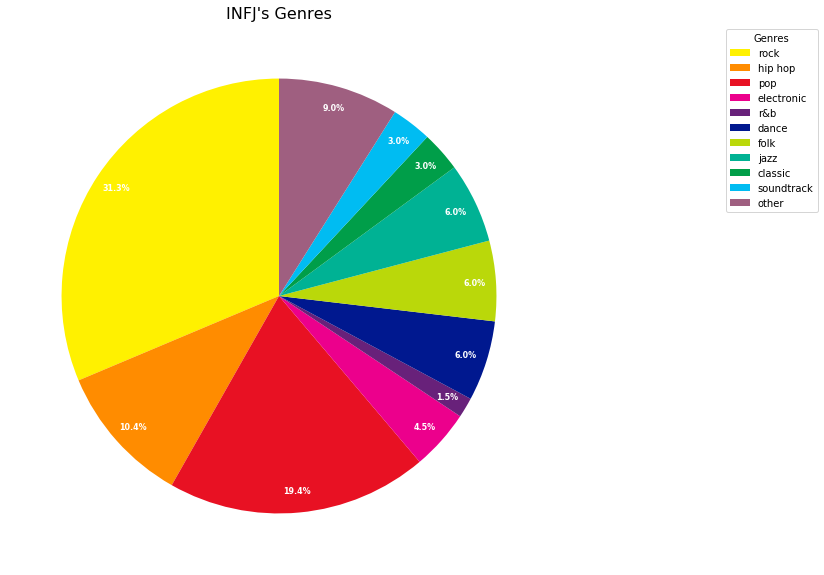

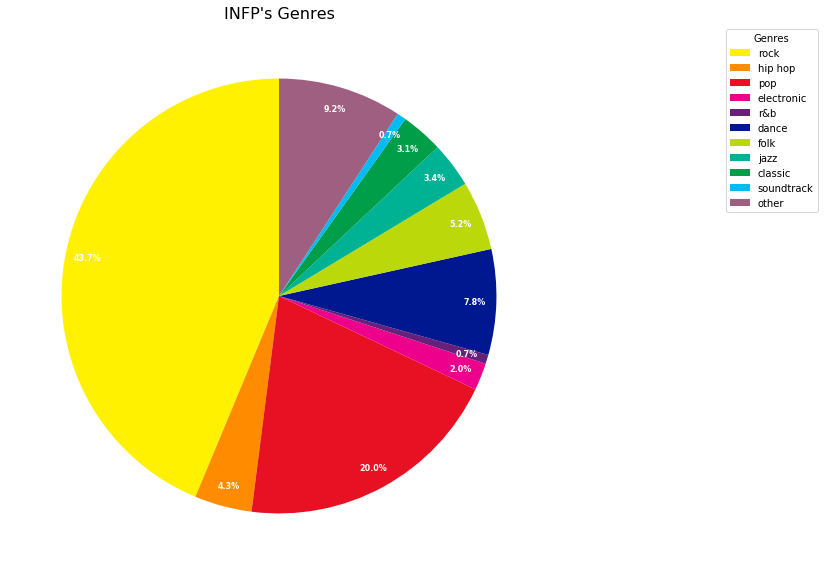

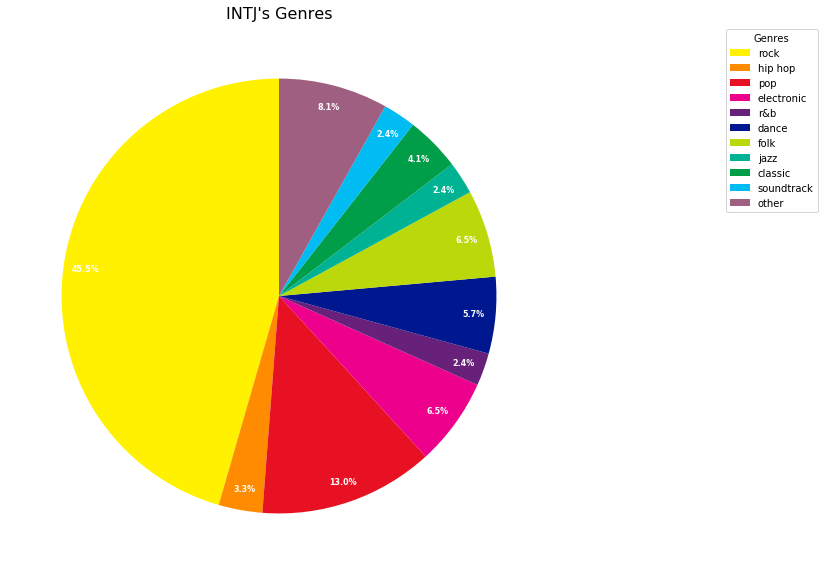

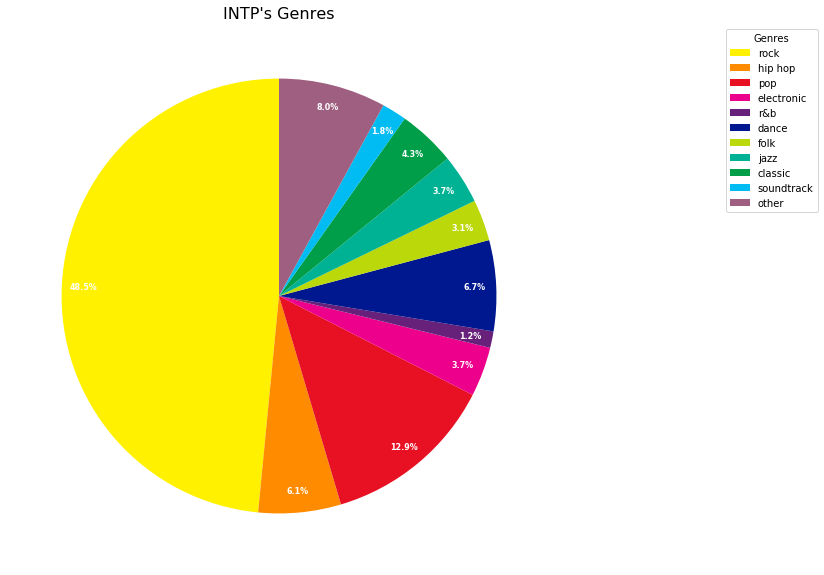

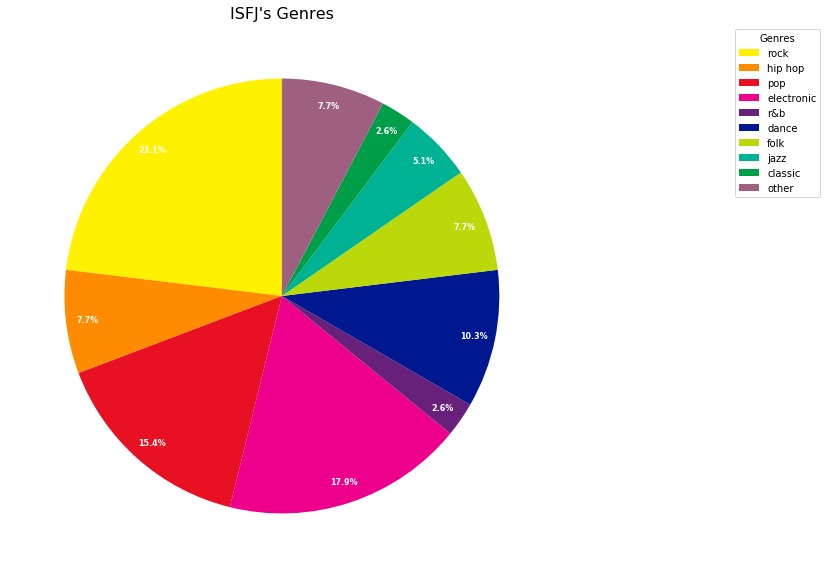

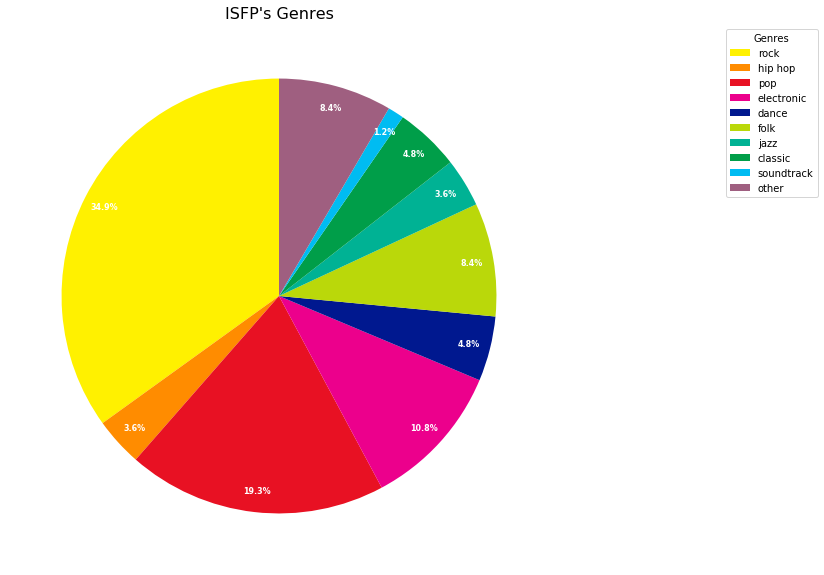

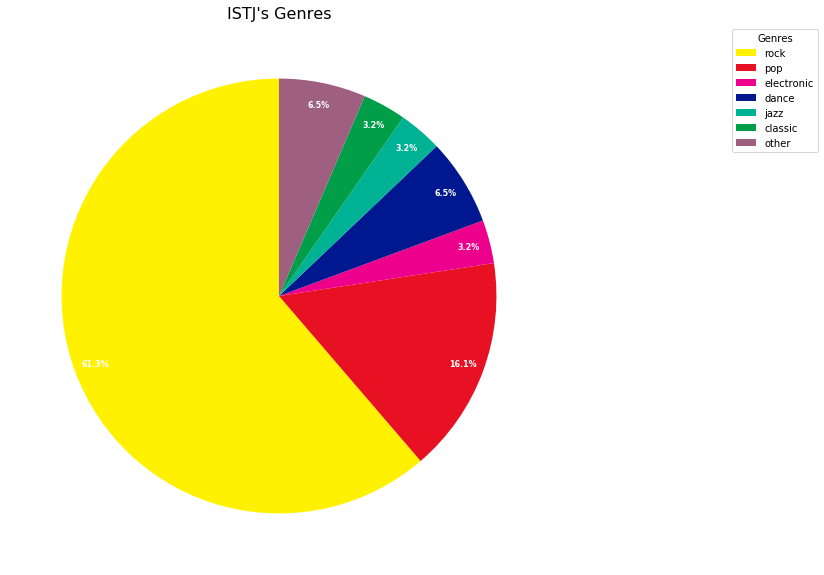

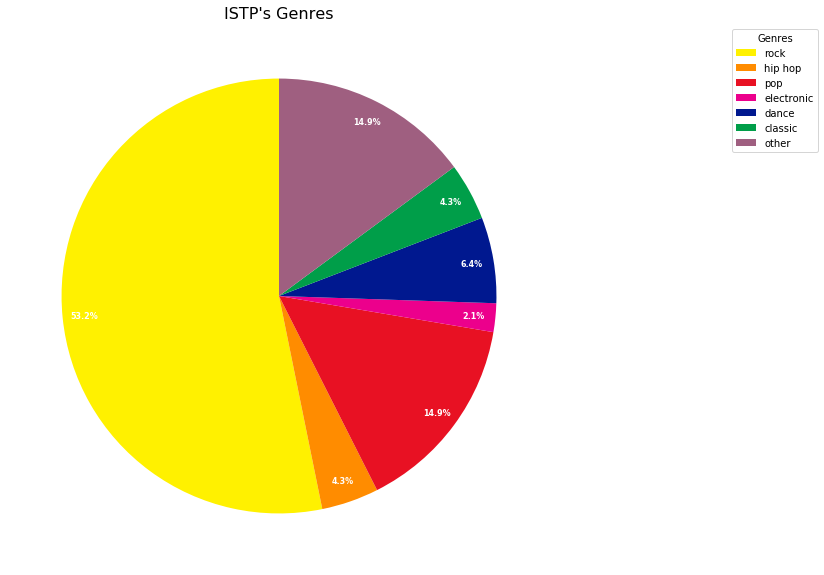

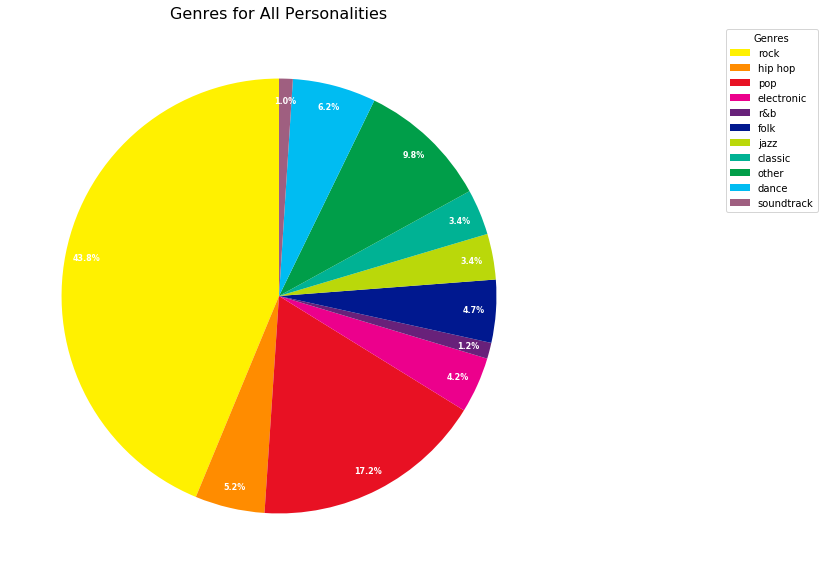

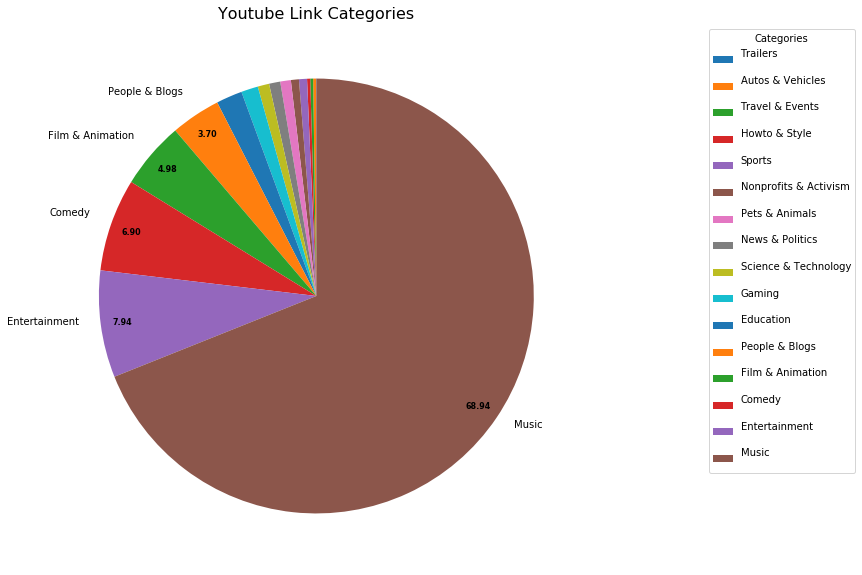

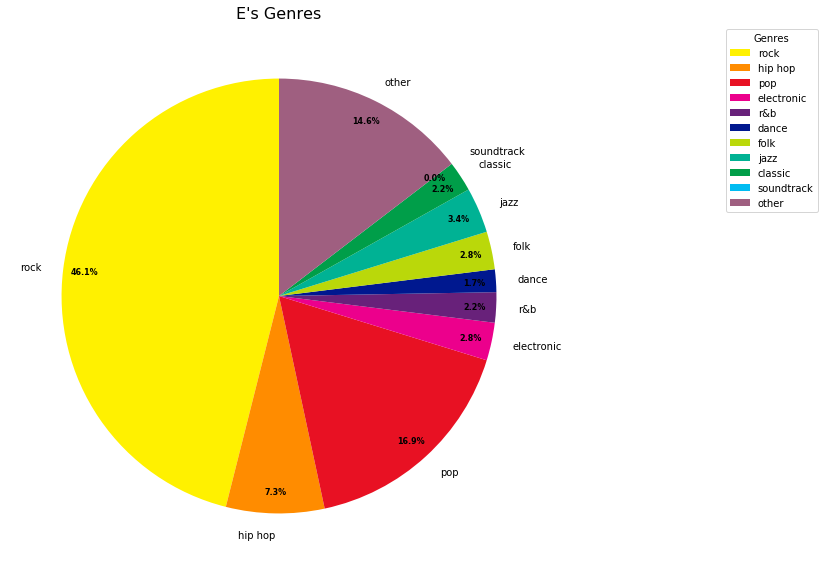

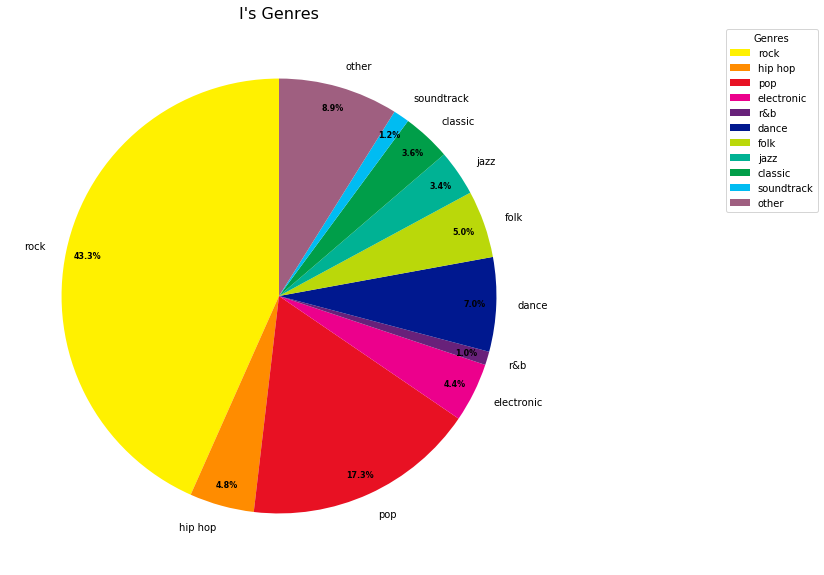

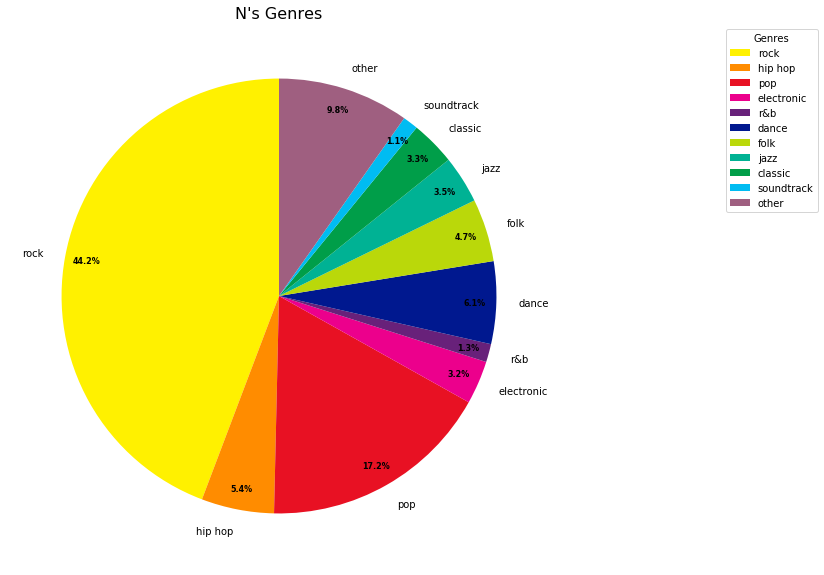

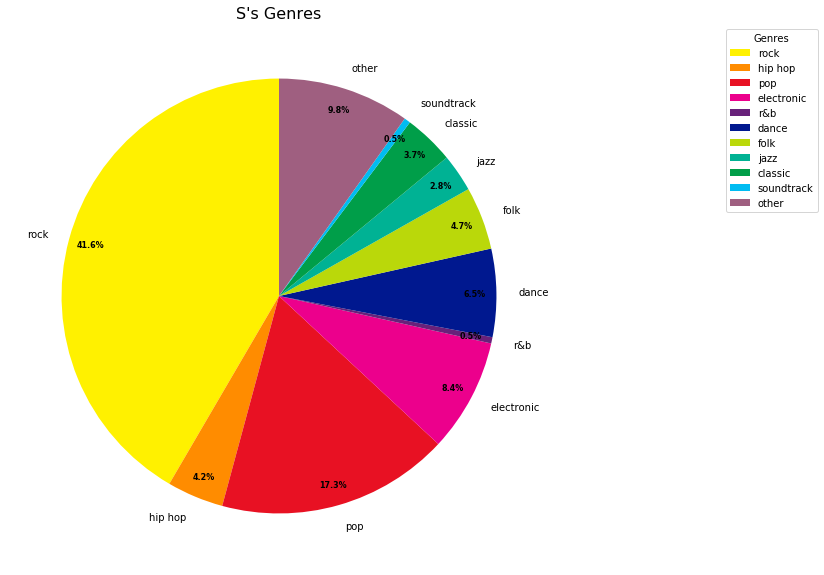

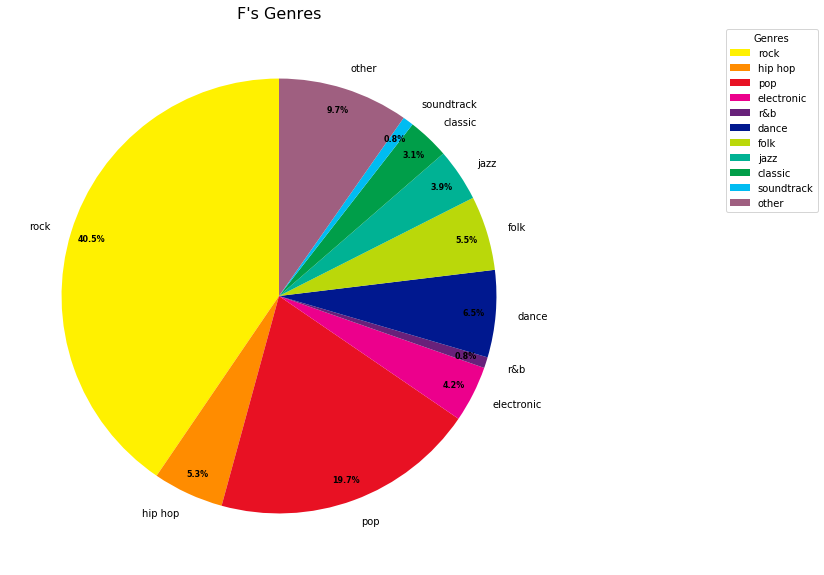

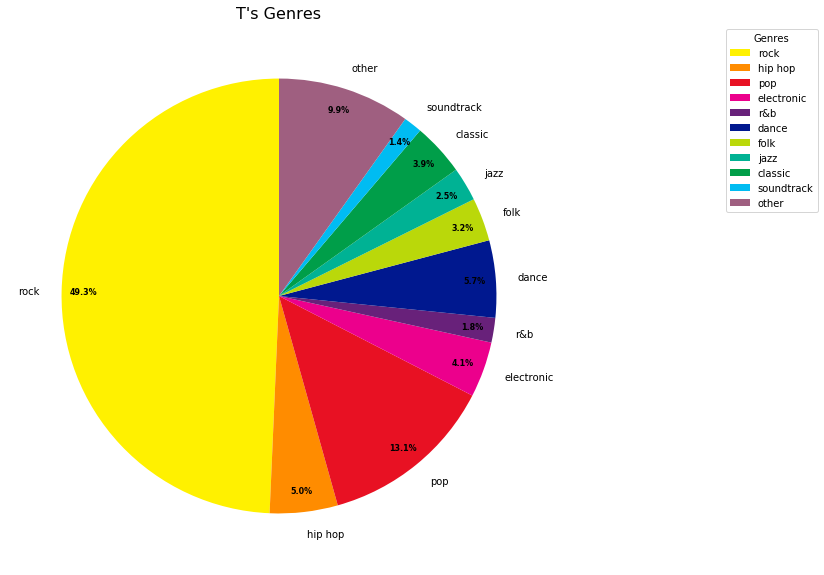

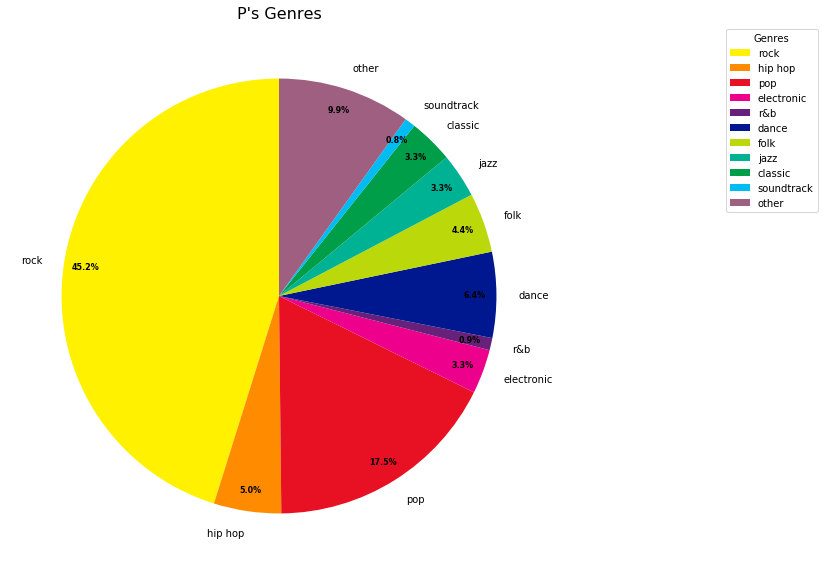

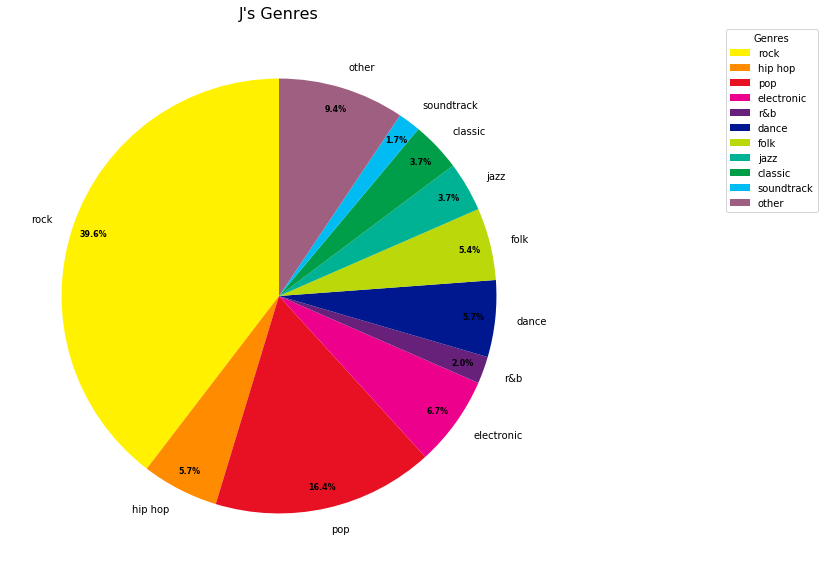

In [92]:
type_list = ["ENFJ", "ENFP", "ENTJ", "ENTP", "ESFJ", "ESFP", "ESTJ", "ESTP", "INFJ", "INFP", "INTJ", "INTP", "ISFJ", "ISFP", "ISTJ", "ISTP"]
genre_list = ["rock","hip hop","pop","electronic","r&b","dance","folk","jazz","classic","soundtrack","other"]
color_list = ["#fff100","#ff8c00","#e81123","#ec008c","#68217a","#00188f","#bad80a","#00b294","#009e49","#00bcf2","#9f5f80","#fcf8ec"]
indicators = ["E","I","N","S","F","T","P","J"]

def find_genre(genre_list):
    '''
    Returns a main genre from a list of genres :genre_list: a list of genres
    '''
    if len(genre_list) == 0:
        return 'other'
    for genre in genre_list:
        if 'rock' in genre or 'metal' in genre or 'punk' in genre:
            return 'rock'
        elif 'rap' in genre or 'hop' in genre or 'hip' in genre:
            return 'hip hop'
        elif 'pop' in genre or 'new mellow' in genre:
            return 'pop'
        elif 'electronic' in genre or 'electro' in genre or 'techno' in genre:
            return 'electronic'
        elif 'r&b' in genre or 'reggae' in genre:
            return 'r&b'
        elif 'dance' in genre or 'house' in genre or 'rave' in genre or 'dubstep' in genre:
            return 'dance'
        elif 'folk' in genre:
            return 'folk'
        elif 'jazz' in genre or 'soul' in genre:
            return 'jazz'
        elif 'classic' in genre or 'piano' in genre:
            return 'classic'
        elif 'soundtrack' in genre or 'broadway' in genre:
            return 'soundtrack'
    if(len(generator) == 0):
        return 'unlisted'
    return 'other'
    

def make_genre_charts():
    '''
    Creates visualization of genre data by personality
    '''
    total_dict = {}
    for personality in type_list:
        input_file = open("link_processing/link_data/spotify-{0}.csv".format(personality)) 
        labels = []
        count = []
        colors = []
        genre_count_dict = {}
        color_index = 0
        while True:
            line = input_file.readline()
            if not line:
                break
            if line.count(',') == 1:
                components = line.split(',')
                genre_count_dict[components[0]] = components[1]
                if(int(components[1]) > 0):   
                    total_dict[components[0]] = total_dict.get(components[0], 0) + int(components[1])
                    labels.append(components[0])
                    count.append(components[1])
                    colors.append(color_list[color_index])
                color_index += 1
        input_file.close()
        if len(labels) > 0:
            fig, ax = plt.subplots(figsize=(20, 10), subplot_kw=dict(aspect="equal"))
            wedges, texts, autotexts = ax.pie(count, labels=labels,autopct='%1.1f%%',
                                    textprops=dict(color="w"),pctdistance=0.9,startangle=90,colors = colors)
            ax.legend(wedges, labels, title="Genres", bbox_to_anchor=(1, 0, 0.5, 1))
            plt.setp(autotexts, size=8,weight="bold")
            ax.set_title("{0}'s Genres".format(personality),size=16)
            plt.show()
    fig, ax = plt.subplots(figsize=(20, 10), subplot_kw=dict(aspect="equal"))
    wedges, texts, autotexts = ax.pie(list(total_dict.values()), labels=list(total_dict.keys()),autopct='%1.1f%%',
                                    textprops=dict(color="w"),pctdistance=0.9,startangle=90,colors = color_list)
    ax.legend(wedges, list(total_dict.keys()), title="Genres", bbox_to_anchor=(1, 0, 0.5, 1))
    plt.setp(autotexts, size=8,weight="bold")
    ax.set_title("Genres for All Personalities",size=16)
    plt.show()


def autopct(pct):
    return ('%.2f' % pct) if pct > 2 else ''

def label_list(data):
    return_list = []
    index = 0
    for k,v in data.items():
        if index > len(list(data.keys())) -  6: 
           return_list.append(k)
        else:
           return_list.append('')
        index += 1
    return return_list


def make_youtube_categories_chart():
    '''
    Makes visualization of youtube category data
    '''
    category_dict = {}
    for personality in type_list:    
        input_file = open('link_processing/link_data/{0}.csv'.format(personality), 'r')
        while True:
            line = input_file.readline()
            if not line:
                break
            components = line.split(',')   
            category_dict[components[2]] = category_dict.get(components[2],0) + 1
        input_file.close()
    category_dict = {k: v for k, v in sorted(category_dict.items(), key=lambda item: item[1])}
    fig, ax = plt.subplots(figsize=(20, 10), subplot_kw=dict(aspect="equal"))
    wedges, texts, autotexts = ax.pie(list(category_dict.values()), labels=label_list(category_dict),autopct=autopct,
                                    textprops=dict(color="k"),pctdistance=0.9,startangle=90)
    ax.legend(wedges, list(category_dict.keys()), title="Categories", bbox_to_anchor=(1, 0, 0.5, 1))
    plt.setp(autotexts, size=8,weight="bold")
    ax.set_title("Youtube Link Categories",size=16)
    plt.show()

def make_genre_charts_per_indicator():
    '''
    Visualizes data on genres by indicator
    '''
    total_dict = {}
    for indicator in indicators:
        total_dict[indicator] = {}
        for genre in genre_list:
            total_dict[indicator][genre] = 0
    for personality in type_list:
        input_file = open("link_processing/link_data/spotify-{0}.csv".format(personality)) 
        while True:
            line = input_file.readline()
            if not line:
                break
            if line.count(',') == 1:
                components = line.split(',')
                if(int(components[1]) > 0):   
                    for indicator in indicators:
                        if indicator in personality:
                            total_dict[indicator][components[0]] = total_dict[indicator].get(components[0],0) + int(components[1])
    for k,v in total_dict.items():
        fig, ax = plt.subplots(figsize=(20, 10), subplot_kw=dict(aspect="equal"))
        wedges, texts, autotexts = ax.pie(list(v.values()), labels=v.keys(),autopct='%1.1f%%',
                                    textprops=dict(color="k"),pctdistance=0.9,startangle=90,colors = color_list)
        ax.legend(wedges,v.keys(), title="Genres", bbox_to_anchor=(1, 0, 0.5, 1))
        plt.setp(autotexts, size=8,weight="bold")
        ax.set_title("{0}'s Genres".format(k),size=16)
        plt.show()
    input_file.close()
        
# Makes data files with Spotify information
# make_genre_files()

#Genre charts for each personality type
make_genre_charts()

#Chart of youtube video categories
make_youtube_categories_chart()

#Genre chart by type indicator
make_genre_charts_per_indicator()

# Basic visualisation of personality types

In [97]:
df['comment_count'] = df['posts'].str.count(pat=r"\|\|\|")+1
df['words'] = df['posts'].apply(lambda x: len(x.split()))
df['words/comment'] = df['words']/df['comment_count']

In [98]:
cnt_srs = df['type'].value_counts()
mean_each=df.groupby('type').agg({'words/comment': 'mean'})
sorted_mean = mean_each.sort_values(by='words/comment')

/Users/kaustavdatta/Downloads/virtualenvs/pytorch/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 7.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/kaustavdatta/Downloads/virtualenvs/pytorch/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 31.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/kaustavdatta/Downloads/virtualenvs/pytorch/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 23.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/kaustavdatta/Downloads/virtualenvs/pytorch/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 42.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

Text(0.5, 1.0, 'Words/Comment for Each Personality')

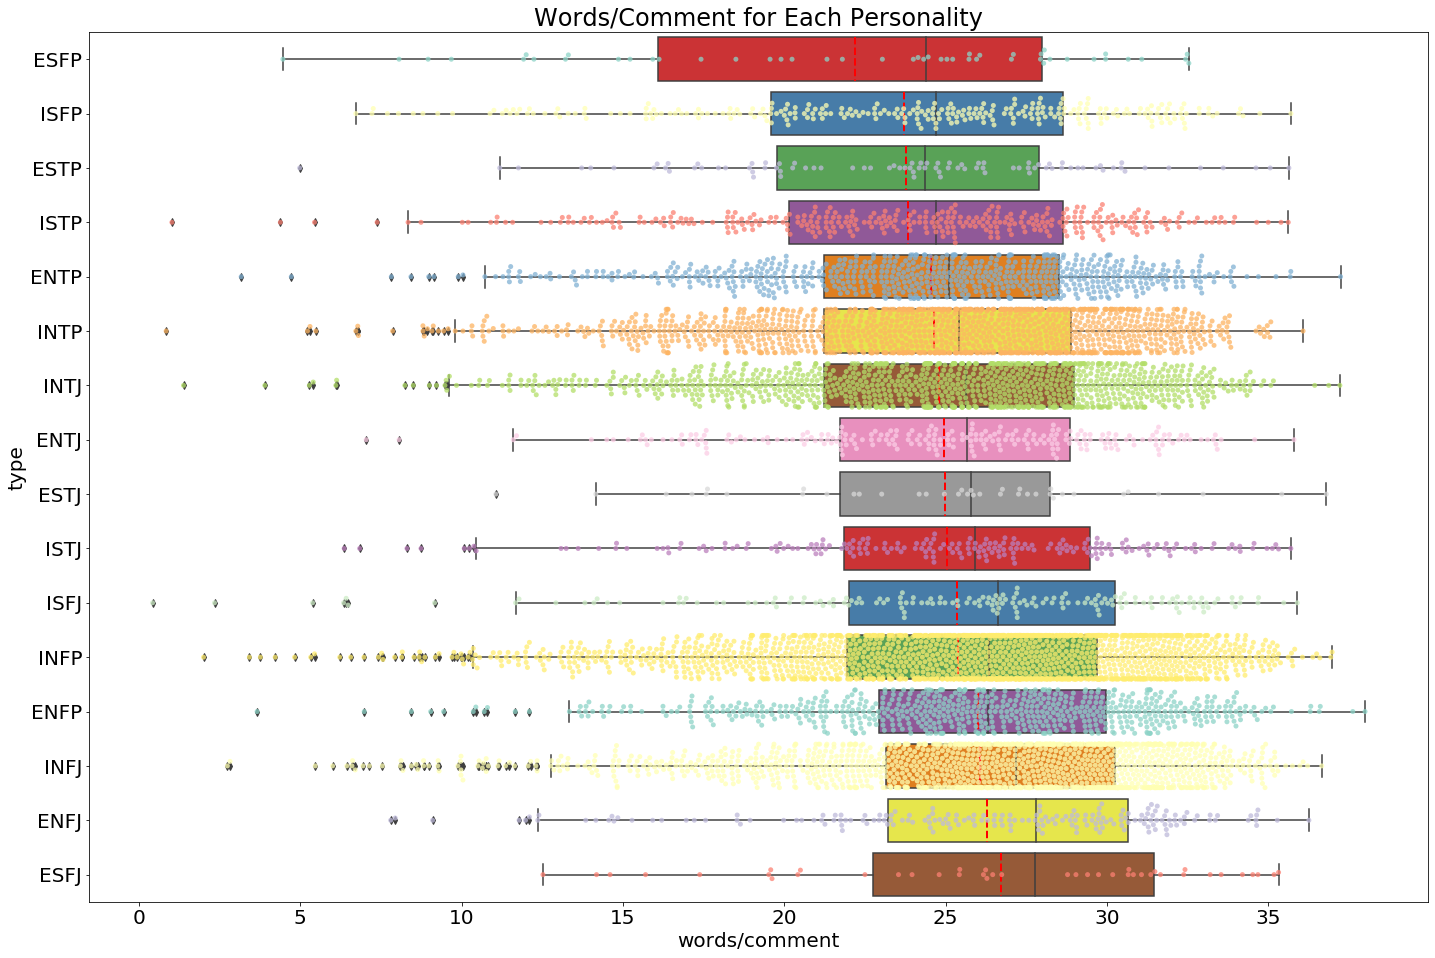

In [99]:
plt.figure(figsize=(24,16))
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.rc('axes', labelsize=20) 
plt.rc('axes', titlesize=20) 
plt.rc('legend', fontsize=20)
sns.boxplot(y='type', x='words/comment', data=df, palette='Set1',showmeans=True, meanline=True,  meanprops={'linestyle':'--','color':'red','linewidth':2},
            order=sorted_mean.index,)
sns.swarmplot(y='type', x='words/comment', data=df, alpha=0.75,palette='Set3',order=sorted_mean.index,).set_title('Words/Comment for Each Personality',fontsize=24)

Text(0.5, 1.0, 'Words/Comment for Each Personality')

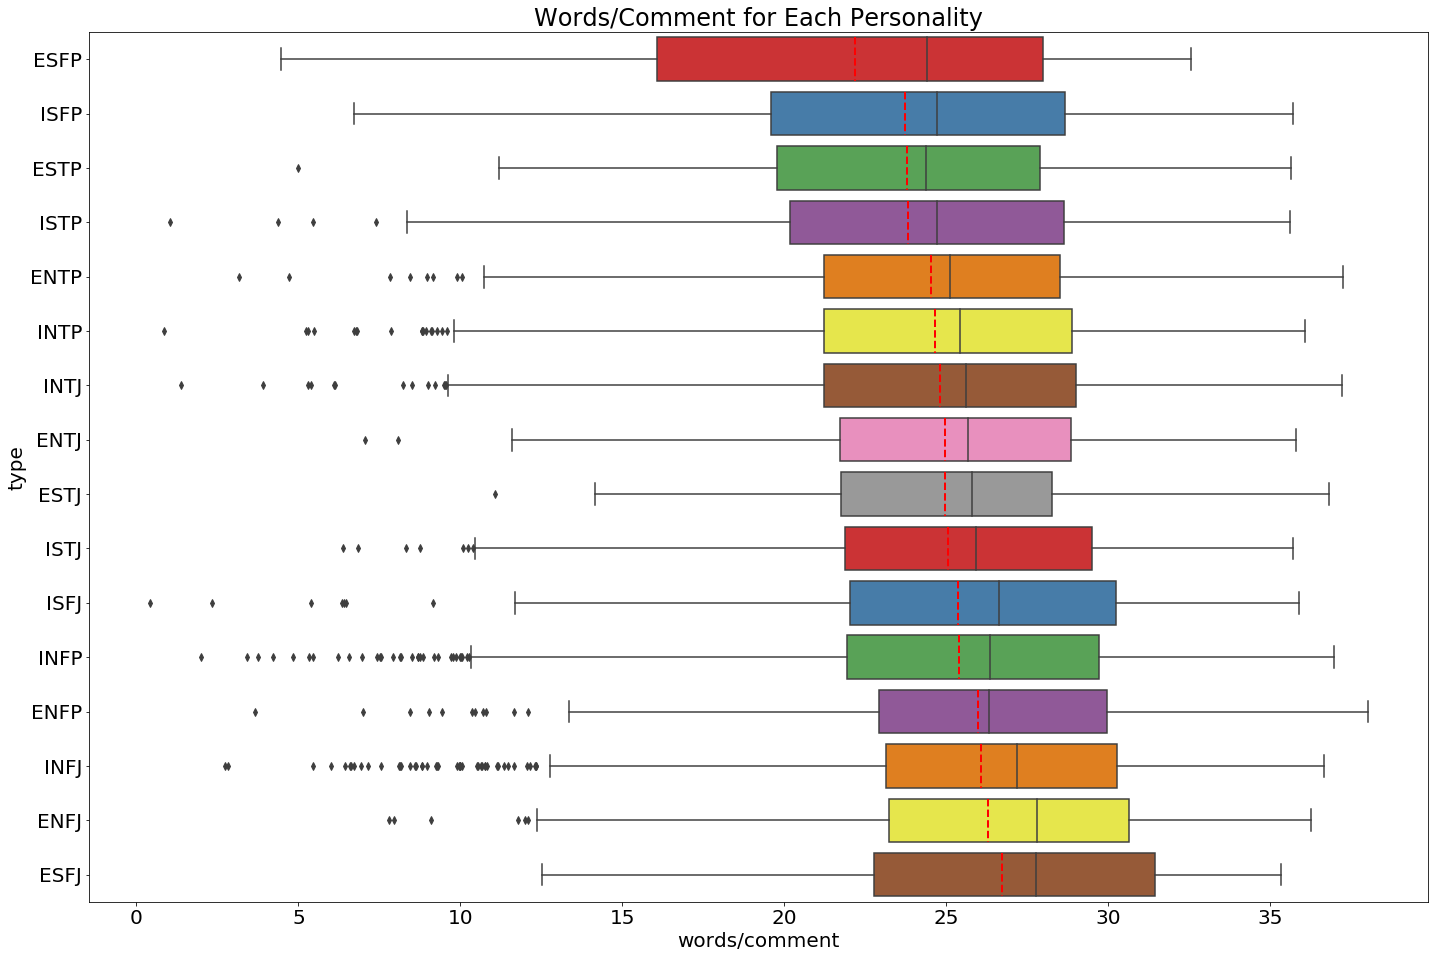

In [100]:
#seperate the upper figure into 2 figures(1)
plt.figure(figsize=(24,16))
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.rc('axes', labelsize=20) 
plt.rc('axes', titlesize=20) 
plt.rc('legend', fontsize=20) 
sns.boxplot( x='words/comment',y='type', data=df, showmeans=True, meanline=True, meanprops={'linestyle':'--','color':'red','linewidth':2},
            order=sorted_mean.index,
            palette='Set1').set_title('Words/Comment for Each Personality',fontsize=24)

/Users/kaustavdatta/Downloads/virtualenvs/pytorch/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 37.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/kaustavdatta/Downloads/virtualenvs/pytorch/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 7.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/kaustavdatta/Downloads/virtualenvs/pytorch/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 31.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/kaustavdatta/Downloads/virtualenvs/pytorch/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 23.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

Text(0.5, 1.0, 'Words/Comment for Each Personality')

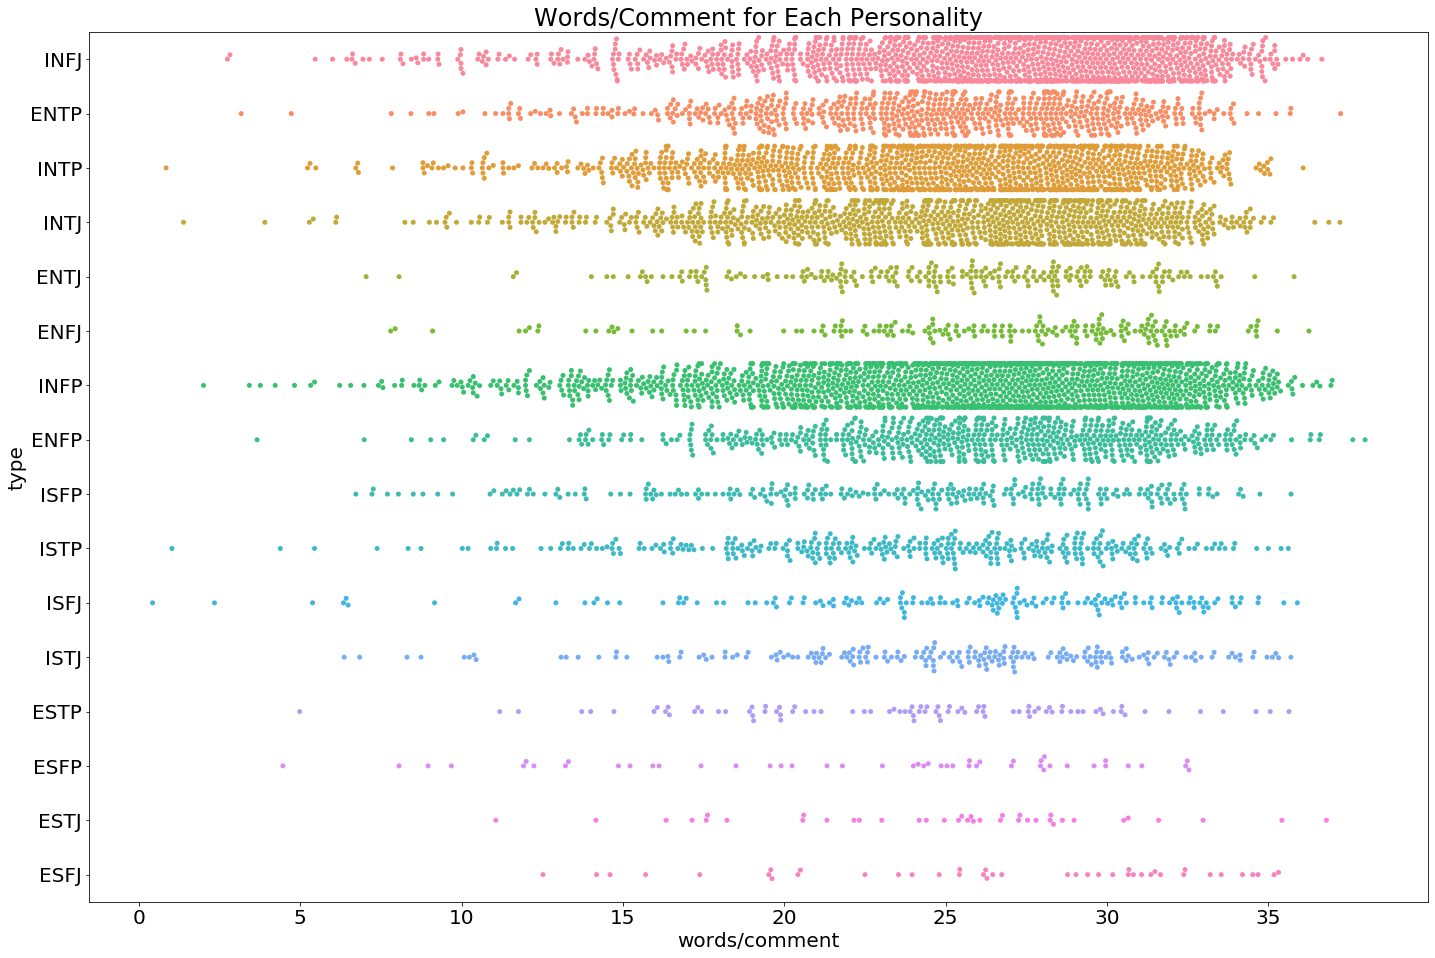

In [101]:
#seperate the upper figure into 2 figures(2)
plt.figure(figsize=(24,16))
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.rc('axes', labelsize=20) 
plt.rc('axes', titlesize=20) 
plt.rc('legend', fontsize=20)
sns.swarmplot(y='type', x='words/comment', data=df).set_title('Words/Comment for Each Personality',fontsize=24)

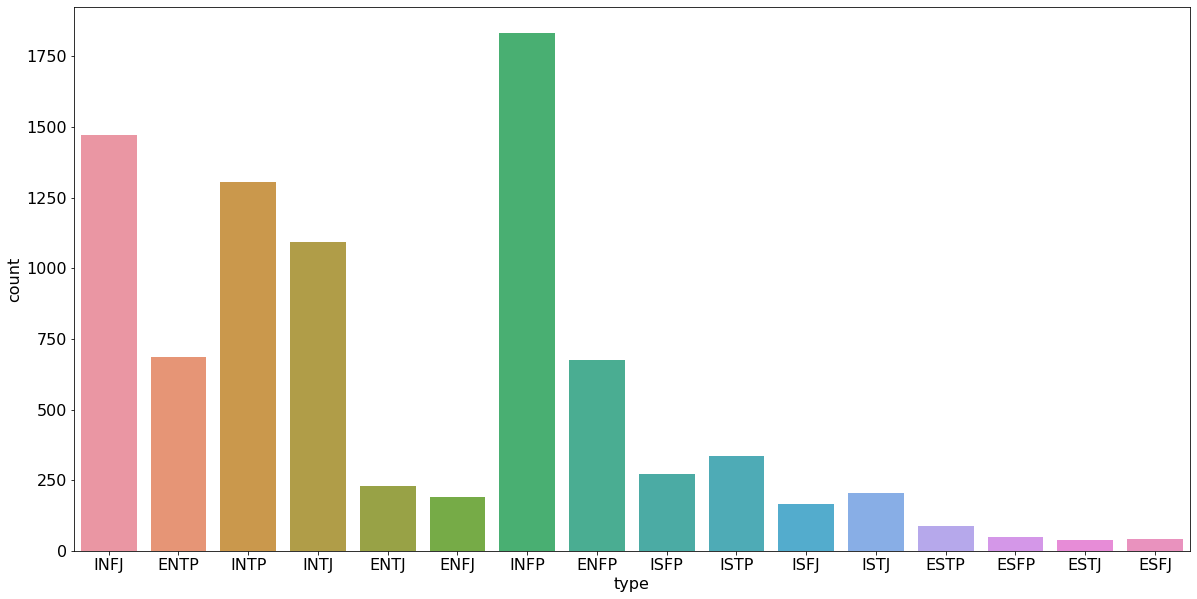

In [102]:
plt.figure(figsize=(20,10))
plt.ylabel('Number of Occurrences', fontsize=16)
plt.xlabel('Personality Types', fontsize=16)
plt.xticks(fontsize=16, rotation=0)
plt.yticks(fontsize=16, rotation=0)
sns.countplot(data=df, x='type')

#sns.countplot(cnt_srs.index, cnt_srs.values)

/Users/kaustavdatta/Downloads/virtualenvs/pytorch/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


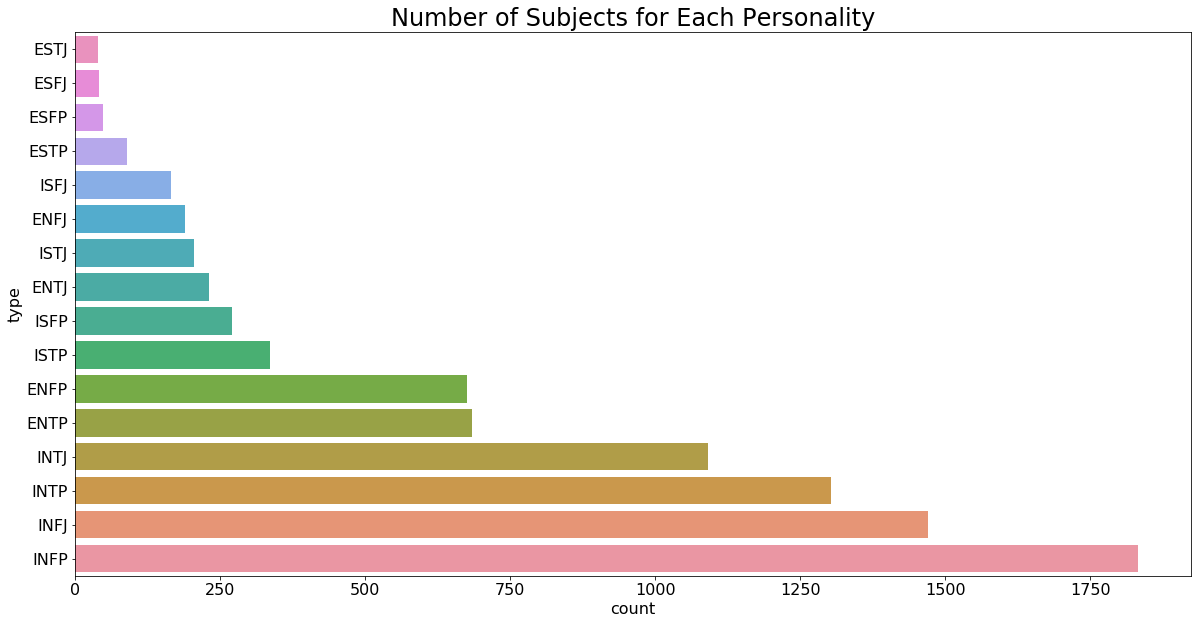

In [103]:
#df = pd.read_csv('/kaggle/input/mbti-type/mbti_1.csv')
# train = pd.read_csv('../input/mbti-type/mbti_1.csv')
mbti = {'I':'Introversion', 'E':'Extroversion', 'N':'Intuition', 
        'S':'Sensing', 'T':'Thinking', 'F': 'Feeling', 
        'J':'Judging', 'P': 'Perceiving'}
plt.figure(figsize=(20,10))
sns.barplot(cnt_srs.values, cnt_srs.index)
plt.gca().invert_yaxis()
plt.ylabel('type', fontsize=16)
plt.xlabel('count', fontsize=16)
plt.xticks(fontsize=16, rotation=0)
plt.yticks(fontsize=16, rotation=0)
plt.title('Number of Subjects for Each Personality',fontsize=24)
plt.show()

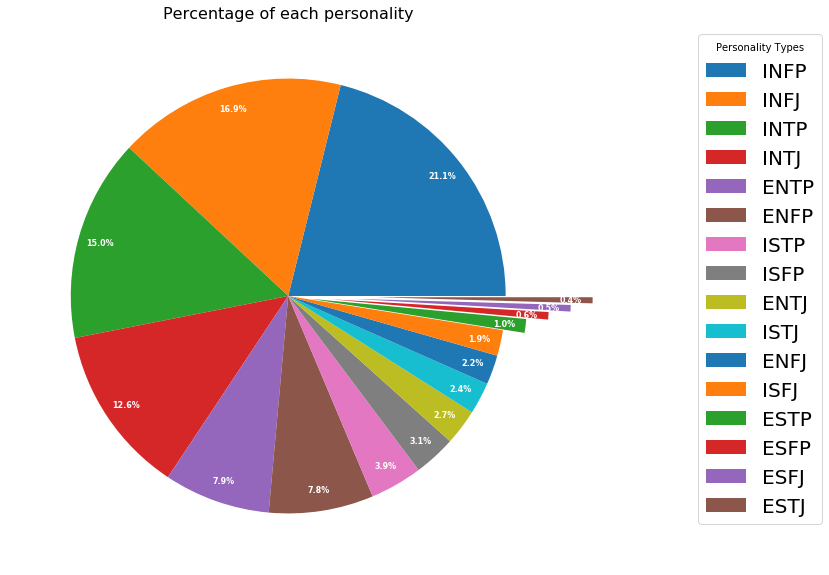

In [104]:
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw=dict(aspect="equal"))
data = cnt_srs.values
ingredients = cnt_srs.index
def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%".format(pct, absolute)
#wedges, texts, autotexts = ax.pie(data, labels=cnt_srs.index,autopct=lambda pct: func(pct, data),
 #                                 textprops=dict(color="w"),pctdistance=0.9,
  #                                explode=(0,0,0,0,0,0,0,0,0,0,0,0,0.1,0.2,0.3,0.4))
wedges, texts, autotexts = ax.pie(data, labels=cnt_srs.values,autopct='%1.1f%%',
                                  textprops=dict(color="w"),pctdistance=0.9,
                                  explode=(0,0,0,0,0,0,0,0,0,0,0,0,0.1,0.2,0.3,0.4))
ax.legend(wedges, ingredients,
          title="Personality Types",
          #loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))
plt.setp(autotexts, size=8,weight="bold")
ax.set_title("Percentage of each personality",size=16)
plt.show()

# Word Cloud and Sentiment Analysis

## Preprocessing text

In [ ]:
stemmer = PorterStemmer()
lemmatiser = WordNetLemmatizer()

cachedStopWords = stopwords.words("english")

def pre_process_data(data, remove_stop_words=True):
    
    data['pp_post']=None

    list_personality = []
    list_posts = []
    len_data = len(data)
    i=0
    
    for row in data.iterrows():
        i+=1
        if i % 500 == 0:
            print("%s | %s rows" % (i, len_data))

        ##### Remove and clean comments
        posts = row[1].posts
        temp = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', posts)
        temp = re.sub("[^a-zA-Z]", " ", temp)
        temp = re.sub(' +', ' ', temp).lower()
        if remove_stop_words:
            temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ') if w not in cachedStopWords])
        else:
            temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ')])
                
        row[1].pp_post = temp
    return data

data_new = pre_process_data(data, remove_stop_words=True)

## Wordcloud using TFIDF 

(-0.5, 799.5, 399.5, -0.5)

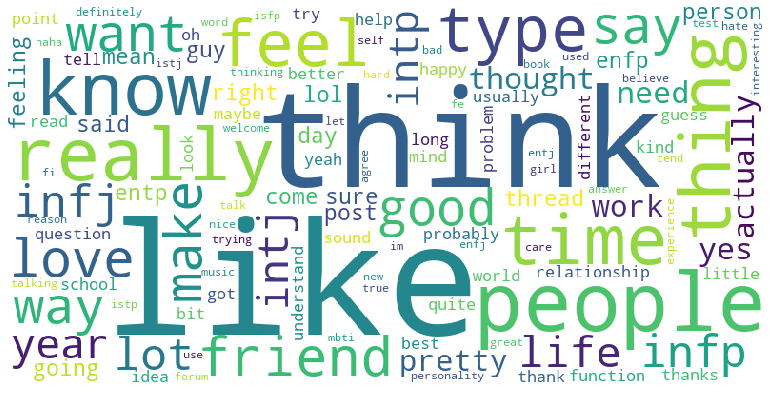

In [49]:
ngrams,categ = 1,"ISFJ"
corpus = data_new['pp_post'].values # get for all possible categories
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(ngrams,ngrams))
vecs = vectorizer.fit_transform(corpus)

feature_names = vectorizer.get_feature_names()
dense = vecs.todense()
lst1 = dense.tolist()
df = pd.DataFrame(lst1, columns=feature_names)

wordcloud = WordCloud(width=800, height=400, background_color="white", max_words=120).generate_from_frequencies(df.T.sum(axis=1))

plt.figure( figsize=(14,7) )
plt.imshow(wordcloud)
plt.axis('off')

## Sentiment Analysis

In [73]:
#Load the dictionary from the pickle file
with open("word_cloud_sentiment/result_dict.pkl","rb") as p:
    result_dict = pickle.load(p)

/Users/kaustavdatta/Downloads/virtualenvs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':


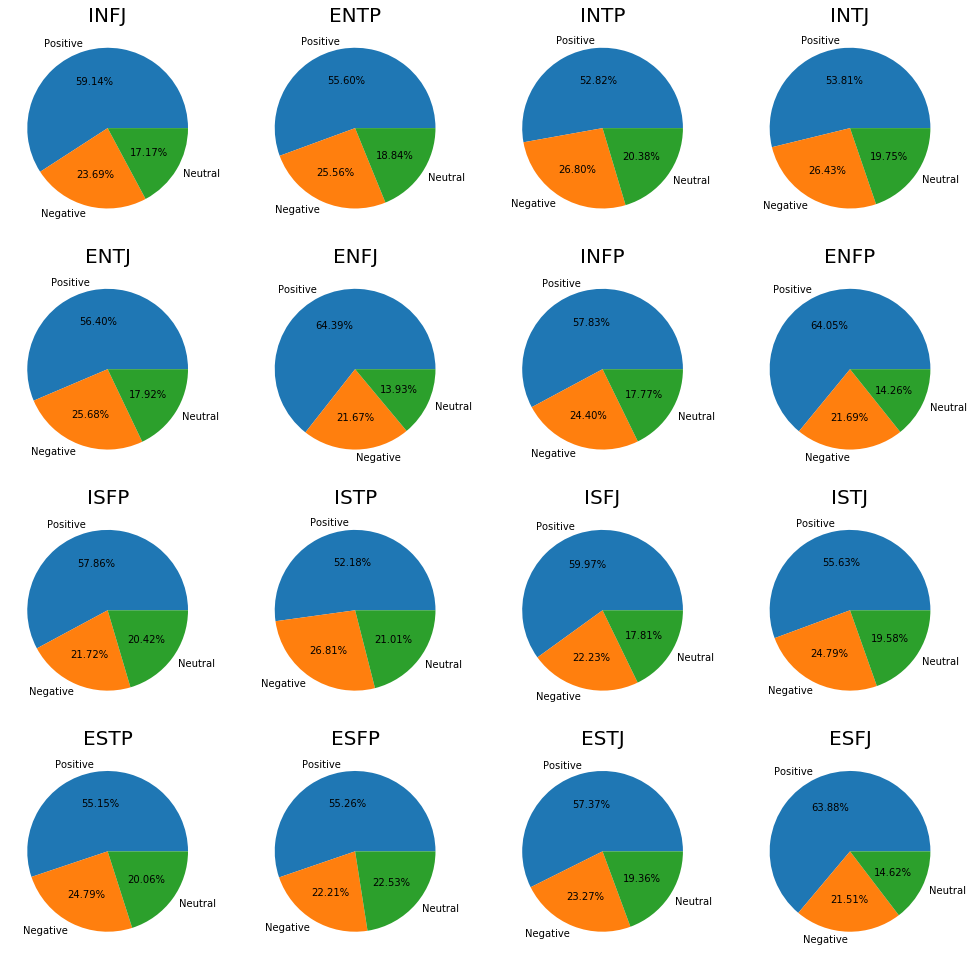

In [74]:
#Plot pie charts, showing percentage of each sentiment type for each personality type
fig, ax = plt.subplots(4, 4, figsize=(17,17))
i,j=0,0
for key, value in result_dict.items():
    sentiment_labels = list(value.keys())
    counts = list(value.values())
    ax[i][j].pie(counts, labels = sentiment_labels,autopct='%1.2f%%')
    ax[i][j].set_title(key, fontsize=20)
    fig.show()
    j+=1    
    if j==4:
        i+=1
        j=0
